In [3]:
# minimal_protein2d.py
# ---------------------------------------------
# 1) Data collection (NCBI) → 2) Preprocess → 3) Model → 4) Train (GIF tracking) → 5) Eval & Plots
# ---------------------------------------------

import os, time, json, random, re, pathlib, requests
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# ---------- Config / Globals ----------
AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")  # 20 standard
AA_TO_IDX = {aa: i+1 for i, aa in enumerate(AMINO_ACIDS)}  # 0=PAD
IDX_TO_LABEL = {0: "H", 1: "E", 2: "C"}
LABELS = {"H": 0, "E": 1, "C": 2}
PAD_IDX = 0

random.seed(42); np.random.seed(42); torch.manual_seed(42)

for d in ["data", "checkpoints", "gifs", "frames", "plots"]:
    os.makedirs(d, exist_ok=True)

# ---------- 1) Data Collection (NCBI FASTA) ----------
EFETCH_URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
USER_EMAIL = os.environ.get("NCBI_EMAIL", "rahman1907028@stud.kuet.ac.bd")

def fetch_fasta(accession: str, retries: int = 3, timeout: int = 20) -> str:
    params = {"db": "protein", "id": accession, "rettype": "fasta", "retmode": "text"}
    headers = {"User-Agent": f"protein-2d/1.0 ({USER_EMAIL})"}
    last_err = None
    for attempt in range(1, retries+1):
        try:
            r = requests.get(EFETCH_URL, params=params, headers=headers, timeout=timeout)
            r.raise_for_status()
            txt = r.text.strip()
            if not txt.startswith(">"):
                raise ValueError(f"Unexpected response for {accession}")
            return txt
        except Exception as e:
            last_err = e
            time.sleep(0.8 * attempt)
    raise RuntimeError(f"Failed to fetch {accession}: {last_err}")

def download_accessions(accessions: List[str], out_path: str) -> None:
    chunks = []
    for acc in accessions:
        print(f"[DL] {acc} ...")
        chunks.append(fetch_fasta(acc))
        time.sleep(0.35)
    with open(out_path, "w") as f:
        f.write("\n".join(chunks) + "\n")
    print(f"[OK] Saved {sum(1 for l in open(out_path) if l.startswith('>'))} sequences to {out_path}")

def parse_fasta(path: str) -> List[Tuple[str, str]]:
    out = []
    if not os.path.exists(path): return out
    sid, seq = None, []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            if line.startswith(">"):
                if sid and seq: out.append((sid, "".join(seq)))
                sid = line[1:].split()[0]; seq = []
            else:
                seq.append(line.upper())
    if sid and seq: out.append((sid, "".join(seq)))
    return out

# ---------- 2) Preprocessing ----------
CF_HELIX_PREF = set("AEHLKMQR")
CF_STRAND_PREF = set("VIFYWT")

def pseudo_secondary_structure(seq: str, w: int = 6) -> str:
    lab = []
    n = len(seq); half = w // 2
    for i in range(n):
        s, e = max(0, i-half), min(n, i+half+1)
        window = seq[s:e]
        h = sum(a in CF_HELIX_PREF for a in window)
        ecount = sum(a in CF_STRAND_PREF for a in window)
        if h >= ecount and h >= (len(window)//2):   lab.append("H")
        elif ecount > h and ecount >= (len(window)//2): lab.append("E")
        else: lab.append("C")
    return "".join(lab)

def tokenize(seq: str) -> List[int]:
    seq = "".join(a if a in AMINO_ACIDS else "A" for a in seq)
    return [AA_TO_IDX.get(a, PAD_IDX) for a in seq]

class ProteinDataset(Dataset):
    def __init__(self, pairs: List[Tuple[str, str]]):
        self.items = []
        for sid, seq in pairs:
            toks = tokenize(seq)
            labels = [LABELS[c] for c in pseudo_secondary_structure(seq)]
            self.items.append((torch.tensor(toks, dtype=torch.long),
                               torch.tensor(labels, dtype=torch.long),
                               sid))
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

def collate_pad(batch):
    toks, labs, sids = zip(*batch)
    Ls = [t.size(0) for t in toks]; maxL = max(Ls)
    T = torch.full((len(batch), maxL), PAD_IDX, dtype=torch.long)
    Y = torch.full((len(batch), maxL), -100, dtype=torch.long)
    M = torch.zeros((len(batch), maxL), dtype=torch.bool)
    for i,(t,l) in enumerate(zip(toks,labs)):
        L = t.size(0); T[i,:L] = t; Y[i,:L] = l; M[i,:L] = True
    return T, Y, M, list(sids)

def split_loaders(pairs, bs=8, seed=42):
    rng = random.Random(seed)
    pairs = pairs[:]
    rng.shuffle(pairs)
    n = len(pairs); n_tr = int(0.7*n); n_val = int(0.85*n)
    tr, va, te = pairs[:n_tr], pairs[n_tr:n_val], pairs[n_val:]
    mk = lambda d, sh: DataLoader(ProteinDataset(d), batch_size=bs, shuffle=sh, collate_fn=collate_pad)
    return mk(tr, True), mk(va, False), mk(te, False)

# ---------- 3) Model (Residual dilated blocks) ----------
class ResidualDilatedConv1D(nn.Module):
    def __init__(self, dim, kernel=5, dilation=1, dropout=0.1):
        super().__init__()
        pad = (kernel - 1) // 2 * dilation
        self.norm1 = nn.LayerNorm(dim)
        self.conv1 = nn.Conv1d(dim, dim, kernel, padding=pad, dilation=dilation)
        self.norm2 = nn.LayerNorm(dim)
        self.conv2 = nn.Conv1d(dim, dim, kernel, padding=pad, dilation=dilation)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, mask):
        r = x
        x = self.norm1(x)
        x = x.transpose(1, 2)
        x = F.gelu(self.conv1(x))
        x = self.drop(x)
        x = self.conv2(x)
        x = x.transpose(1, 2)
        x = self.drop(x) + r
        x = self.norm2(x)
        return x

class CNNProteinSS(nn.Module):
    def __init__(self,
                 vocab_size=len(AA_TO_IDX)+1,
                 d_model=128,
                 num_classes=3,
                 dropout=0.1,
                 cnn_depth=6,
                 kernel=5):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)
        self.pos = nn.Parameter(torch.randn(1, 2048, d_model) * 0.01)
        dilations = [1, 2, 4] * ((cnn_depth + 2) // 3)
        self.blocks = nn.ModuleList(
            [ResidualDilatedConv1D(d_model, kernel=kernel, dilation=d, dropout=dropout)
             for d in dilations[:cnn_depth]]
        )
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, tokens, mask):
        B, L = tokens.shape
        x = self.embed(tokens)
        x = x + self.pos[:, :L, :]
        for blk in self.blocks:
            x = blk(x, mask)
        logits = self.head(x)
        return logits

# ---------- 4) Training (with per-epoch weight GIFs) ----------
def masked_ce(logits, labels): #cross entropy
    return F.cross_entropy(logits.reshape(-1, logits.size(-1)), labels.reshape(-1), ignore_index=-100)

def q3(logits, labels):
    with torch.no_grad():
        pred = logits.argmax(-1)
        m = labels != -100
        if m.sum().item() == 0: return 0.0
        return ((pred==labels) & m).sum().item() / m.sum().item()

def _weight_to_array(W: torch.Tensor):
    W = W.detach().cpu().float()
    if W.ndim <= 2:
        arr = W.numpy()
        if arr.ndim == 1: arr = arr[None, :]
        return arr
    return W.reshape(W.size(0), -1).numpy()

def _save_frame(tensor, title, path, vmax=None):
    arr = _weight_to_array(tensor)
    plt.figure(figsize=(6,4))
    plt.imshow(arr, aspect='auto', interpolation='nearest', vmax=vmax, vmin=(-vmax if vmax else None))
    plt.colorbar(); plt.title(title)
    plt.tight_layout(); plt.savefig(path, dpi=120); plt.close()

def make_gifs(tracks, fps=2):
    for name, tensors in tracks.items():
        if not tensors: continue
        vmax = max(float(t.abs().max().cpu()) for t in tensors) or 1.0
        safe = re.sub(r"[^a-zA-Z0-9_]+", "_", name)
        frame_dir = os.path.join("frames", safe); os.makedirs(frame_dir, exist_ok=True)
        imgs = []
        for e, t in enumerate(tensors, 1):
            frame_path = os.path.join(frame_dir, f"epoch_{e:03d}.png")
            _save_frame(t, f"{name} (epoch {e})", frame_path, vmax=vmax)
            imgs.append(imageio.imread(frame_path))
        gif_path = os.path.join("gifs", f"{safe}.gif")
        imageio.mimsave(gif_path, imgs, fps=fps, loop=0)
        print(f"[GIF] {gif_path}")

def enumerate_trackables(model, include_bias=True, include_norm=True, include_pos=True, regex=None, explicit=None):
    items = []
    if explicit:
        for name in explicit:
            def _mk(name=name):
                def get(m):
                    obj = m
                    for part in name.split("."):
                        obj = obj[int(part)] if part.isdigit() else getattr(obj, part)
                    return obj
                return get
            items.append((name, _mk()))
        return items
    for full_name, p in model.named_parameters(recurse=True):
        if not include_pos and ("pos" in full_name): continue
        if not include_norm and any(k in full_name.lower() for k in ["norm","ln","layernorm"]): continue
        if ("weight" in full_name) or (include_bias and "bias" in full_name):
            if (regex is None) or (re.search(regex, full_name) is not None):
                def _mk(full_name=full_name):
                    def get(m):
                        obj = m
                        parts = full_name.split(".")
                        for i, part in enumerate(parts):
                            if i == len(parts)-1: return getattr(obj, part)
                            obj = obj[int(part)] if part.isdigit() else getattr(obj, part)
                    return get
                items.append((full_name, _mk()))
    return items

def train_with_history(model, tr_loader, va_loader, epochs=10, lr=3e-4, wd=1e-4,
                       device=None, track_layers="all", include_bias=True,
                       include_norm=True, include_pos=True, gif_fps=2):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] device={device}")
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) #Adam optimizer
    best = -1.0
    history = {"epoch": [], "tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}

    if isinstance(track_layers, list):
        tracked_items = enumerate_trackables(model, include_bias, include_norm, include_pos, explicit=track_layers)
    elif track_layers == "all":
        tracked_items = enumerate_trackables(model, include_bias, include_norm, include_pos)
    elif track_layers is None:
        tracked_items = []
    else:
        tracked_items = enumerate_trackables(model, include_bias, include_norm, include_pos, regex=track_layers)
    tracked = {name: [] for name, _ in tracked_items}
    if tracked: print(f"[TRACK] {len(tracked)} tensors to visualize")

    for epoch in range(1, epochs+1):
        model.train()
        tr_loss = tr_acc = steps = 0
        for T, Y, M, _ in tr_loader:
            T, Y, M = T.to(device), Y.to(device), M.to(device)
            logits = model(T, M)
            loss = masked_ce(logits, Y)
            opt.zero_grad(set_to_none=True); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tr_loss += loss.item(); tr_acc += q3(logits.detach(), Y); steps += 1
        tr_loss /= max(1, steps); tr_acc /= max(1, steps)

        model.eval()
        va_loss = va_acc = va_steps = 0
        with torch.no_grad():
            for T, Y, M, _ in va_loader:
                T, Y, M = T.to(device), Y.to(device), M.to(device)
                logits = model(T, M)
                va_loss += masked_ce(logits, Y).item()
                va_acc  += q3(logits, Y); va_steps += 1
        va_loss /= max(1, va_steps); va_acc /= max(1, va_steps)
        print(f"[E{epoch:02d}] loss_tr={tr_loss:.4f} acc_tr={tr_acc:.3f}  loss_val={va_loss:.4f} acc_val={va_acc:.3f}")

        history["epoch"].append(epoch)
        history["tr_loss"].append(tr_loss); history["tr_acc"].append(tr_acc)
        history["va_loss"].append(va_loss); history["va_acc"].append(va_acc)

        for name, getter in tracked_items:
            tensor = getter(model)
            if tensor is not None:
                tracked[name].append(tensor.detach().cpu().clone())

        if va_acc > best:
            best = va_acc
            torch.save({"model": model.state_dict(), "val_q3": va_acc}, "checkpoints/best.pt")
            print(f"[CKPT] saved (val Q3={va_acc:.3f})")

    if tracked: make_gifs(tracked, fps=gif_fps)
    return history

# ---------- 5) Evaluation & Visualization ----------
def plot_curves(history, save_dir="plots"):
    os.makedirs(save_dir, exist_ok=True)
    ep = history.get("epoch", [])
    if not ep: return
    # Loss
    fig = plt.figure()
    plt.plot(ep, history["tr_loss"], label="train")
    plt.plot(ep, history["va_loss"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss over epochs"); plt.legend(); plt.tight_layout()
    p = os.path.join(save_dir, "loss.png"); fig.savefig(p, dpi=150); plt.close(fig); print(f"[SAVE] {p}")
    # Accuracy
    fig = plt.figure()
    plt.plot(ep, history["tr_acc"], label="train")
    plt.plot(ep, history["va_acc"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (Q3)"); plt.title("Accuracy over epochs"); plt.legend(); plt.tight_layout()
    p = os.path.join(save_dir, "accuracy.png"); fig.savefig(p, dpi=150); plt.close(fig); print(f"[SAVE] {p}")

def confusion_matrix_test(model, te_loader, num_classes=3, device=None, normalize=True, save_dir="plots"):
    os.makedirs(save_dir, exist_ok=True)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()
    cm = torch.zeros(num_classes, num_classes, dtype=torch.long)
    with torch.no_grad():
        for T, Y, M, _ in te_loader:
            T, Y, M = T.to(device), Y.to(device), M.to(device)
            logits = model(T, M)
            pred = logits.argmax(-1)
            mask = (Y != -100)
            y_true = Y[mask].view(-1); y_pred = pred[mask].view(-1)
            for t, p in zip(y_true, y_pred): cm[t, p] += 1
    cm_np = cm.cpu().numpy()
    cm_disp = (cm_np / np.clip(cm_np.sum(axis=1, keepdims=True), 1, None)) if normalize else cm_np
    labels = ["H","E","C"]
    fig = plt.figure(figsize=(5,4))
    im = plt.imshow(cm_disp, aspect="auto", interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(num_classes), labels); plt.yticks(range(num_classes), labels)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"Confusion Matrix (test){' – normalized' if normalize else ''}")
    for i in range(num_classes):
        for j in range(num_classes):
            txt = f"{cm_disp[i,j]:.2f}" if normalize else str(cm_np[i,j])
            plt.text(j, i, txt, ha="center", va="center")
    plt.tight_layout()
    p = os.path.join(save_dir, "confusion_matrix.png"); fig.savefig(p, dpi=150); plt.close(fig); print(f"[SAVE] {p}")
    return cm_np

def evaluate_test_metrics(model, te_loader, num_classes=3, device=None, average="macro"):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for T, Y, M, _ in te_loader:
            T, Y, M = T.to(device), Y.to(device), M.to(device)
            logits = model(T, M)
            preds = logits.argmax(-1)
            mask = (Y != -100)
            all_true.extend(Y[mask].cpu().numpy().tolist())
            all_pred.extend(preds[mask].cpu().numpy().tolist())
    all_true = np.array(all_true); all_pred = np.array(all_pred)
    acc = accuracy_score(all_true, all_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true, all_pred, labels=range(num_classes), average=average, zero_division=0
    )
    p_pc, r_pc, f_pc, _ = precision_recall_fscore_support(
        all_true, all_pred, labels=range(num_classes), average=None, zero_division=0
    )
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1,
            "precision_per_class": p_pc, "recall_per_class": r_pc, "f1_per_class": f_pc}

# ---------- Main ----------
if __name__ == "__main__":
    fasta_path = "data/proteins.fasta"
    accessions = [
        "NP_000509.1",   # Human hemoglobin beta (HBB)
        "NP_000336.1",   # Human alpha-synuclein (SNCA)
        "NP_990612.2",   # Chicken lysozyme C
        "AAA27722.1",    # Aequorea victoria GFP
        "NP_414555.1",   # E. coli DnaK (K-12)
        "NP_417179",     # E. coli RecA (K-12)
    ]
    if not os.path.exists(fasta_path):
        download_accessions(accessions, fasta_path)

    pairs = parse_fasta(fasta_path)
    if not pairs:
        raise SystemExit("No sequences found. Check FASTA download.")

    tr_loader, va_loader, te_loader = split_loaders(pairs, bs=8)

    model = CNNProteinSS(d_model=128, cnn_depth=6, kernel=5, dropout=0.1, num_classes=3)

    history = train_with_history(
        model, tr_loader, va_loader,
        epochs=12, lr=3e-4, wd=1e-4,
        # Track embed, both convs in residual blocks, and the linear layers in head (nn.Sequential)
        track_layers=r"(embed\.weight|blocks\.\d+\.(conv1|conv2)\.(weight|bias)|head\.\d+\.weight)",
        include_bias=True, include_norm=True, include_pos=True, gif_fps=2
    )

    plot_curves(history)

    # Reload best before test eval
    ckpt = torch.load("checkpoints/best.pt", map_location="cpu")
    model.load_state_dict(ckpt["model"])

    # Confusion matrix + metrics
    _ = confusion_matrix_test(model, te_loader, num_classes=3, normalize=True)
    metrics = evaluate_test_metrics(model, te_loader, num_classes=3, average="macro")

    print("\n[TEST METRICS]")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-score:  {metrics['f1']:.4f}")

    print("\n[PER-CLASS] (H, E, C)")
    for cls_name, p, r, f in zip(["H","E","C"], metrics["precision_per_class"],
                                  metrics["recall_per_class"], metrics["f1_per_class"]):
        print(f"{cls_name}: P={p:.4f} R={r:.4f} F1={f:.4f}")


[INFO] device=cpu
[TRACK] 27 tensors to visualize
[E01] loss_tr=1.0977 acc_tr=0.371  loss_val=0.9703 acc_val=0.687
[CKPT] saved (val Q3=0.687)
[E02] loss_tr=0.9787 acc_tr=0.622  loss_val=0.8900 acc_val=0.701
[CKPT] saved (val Q3=0.701)
[E03] loss_tr=0.9070 acc_tr=0.646  loss_val=0.8371 acc_val=0.701
[E04] loss_tr=0.8637 acc_tr=0.645  loss_val=0.8066 acc_val=0.701
[E05] loss_tr=0.8411 acc_tr=0.645  loss_val=0.7918 acc_val=0.701
[E06] loss_tr=0.8150 acc_tr=0.645  loss_val=0.7808 acc_val=0.701
[E07] loss_tr=0.7954 acc_tr=0.645  loss_val=0.7682 acc_val=0.701
[E08] loss_tr=0.7657 acc_tr=0.645  loss_val=0.7575 acc_val=0.701
[E09] loss_tr=0.7303 acc_tr=0.648  loss_val=0.7523 acc_val=0.707
[CKPT] saved (val Q3=0.707)
[E10] loss_tr=0.7020 acc_tr=0.680  loss_val=0.7482 acc_val=0.714
[CKPT] saved (val Q3=0.714)
[E11] loss_tr=0.6707 acc_tr=0.734  loss_val=0.7363 acc_val=0.721
[CKPT] saved (val Q3=0.721)
[E12] loss_tr=0.6418 acc_tr=0.773  loss_val=0.7106 acc_val=0.735
[CKPT] saved (val Q3=0.735)
[G


[ARTIFACTS]
GIFs:
• /content/gifs/blocks_0_conv1_bias.gif  (exists=True)
• /content/gifs/blocks_0_conv1_weight.gif  (exists=True)
• /content/gifs/blocks_0_conv2_bias.gif  (exists=True)
• /content/gifs/blocks_0_conv2_weight.gif  (exists=True)
• /content/gifs/blocks_1_conv1_bias.gif  (exists=True)
• /content/gifs/blocks_1_conv1_weight.gif  (exists=True)

Figures:
• /content/plots/loss.png  (exists=True)
• /content/plots/accuracy.png  (exists=True)
• /content/plots/confusion_matrix.png  (exists=True)


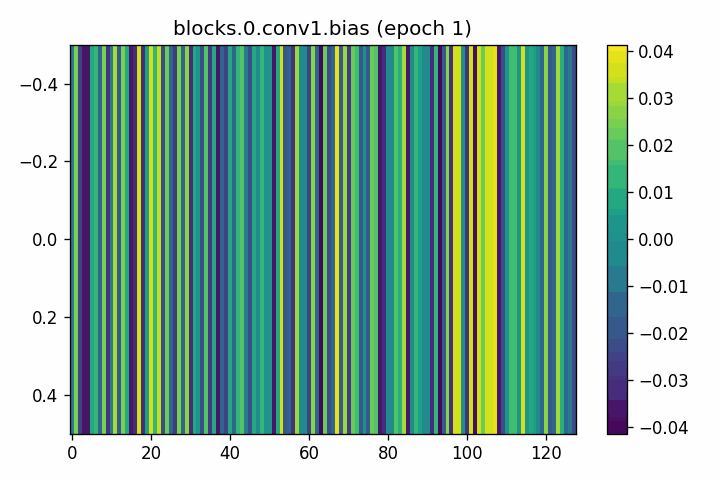

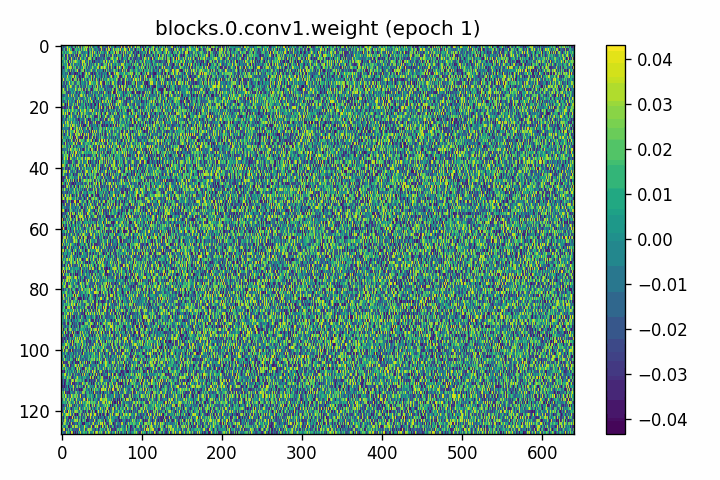

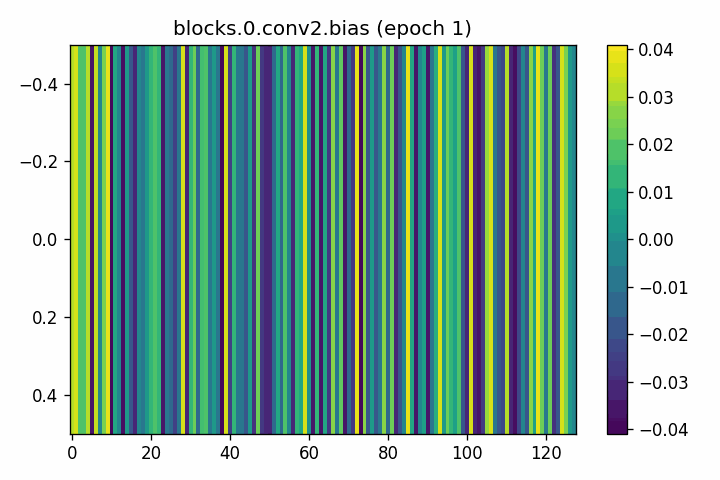

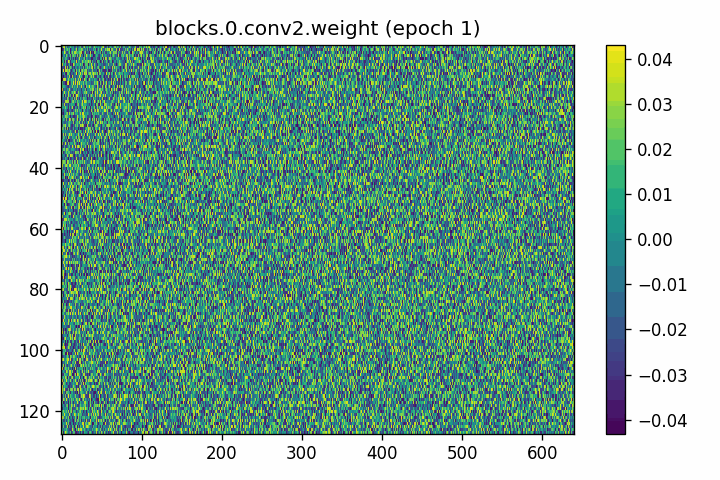

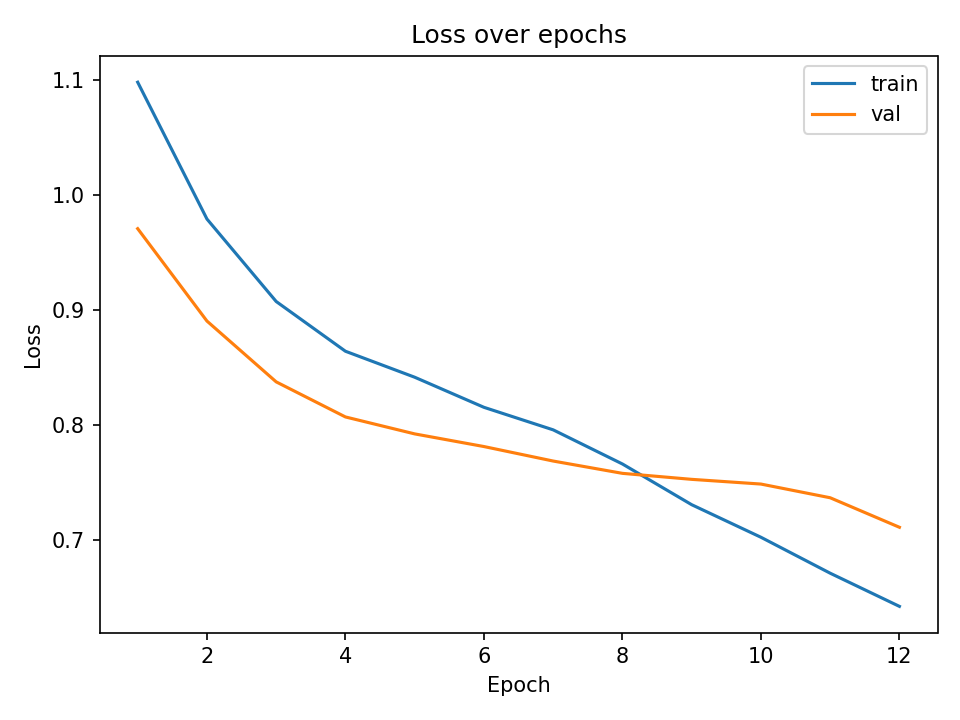

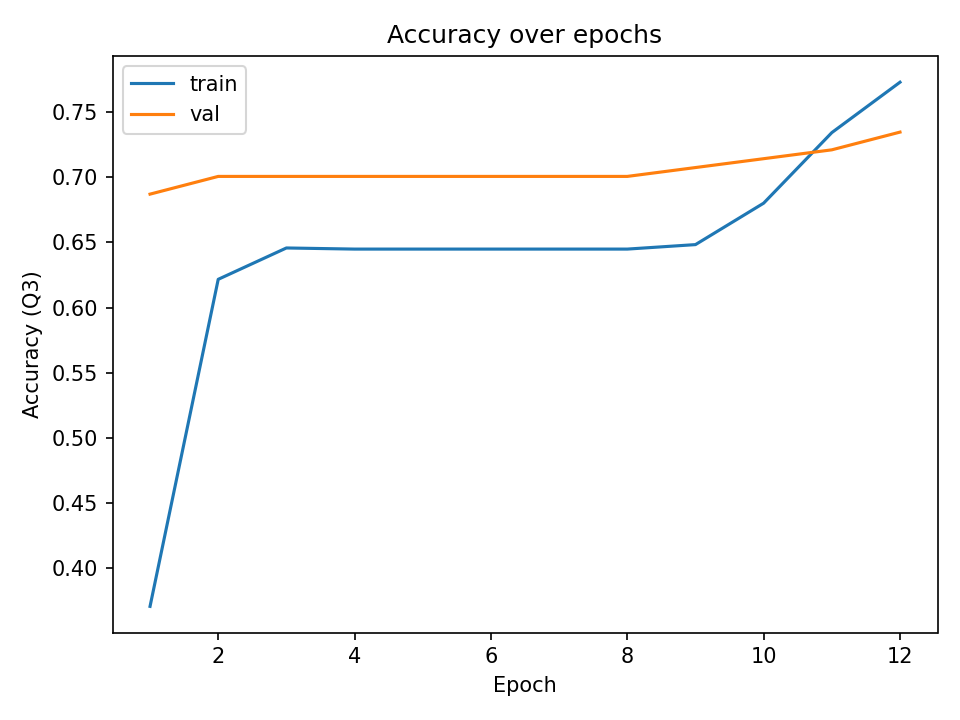

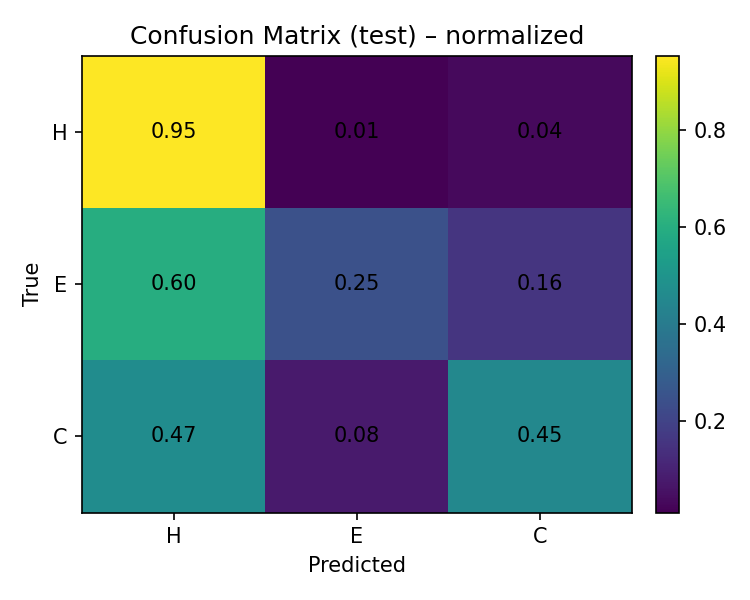

In [4]:
# ---- View saved GIFs and figures (for notebooks/Colab/VSCode) ----
import os, glob
from pathlib import Path
try:
    from IPython.display import Image, display
    in_notebook = True
except Exception:
    in_notebook = False

def _pp(path):
    p = Path(path).resolve()
    print(f"• {p}  (exists={p.exists()})")
    return str(p)

print("\n[ARTIFACTS]")
gif_files = sorted(glob.glob("gifs/*.gif"))
png_files = [ "plots/loss.png", "plots/accuracy.png", "plots/confusion_matrix.png" ]

print("GIFs:")
for g in gif_files[:6]: _pp(g)
if not gif_files:
    print("• No GIFs found. Try: pip install pillow  | and/or set track_layers='all' for a quick 2–3 epoch run.")

print("\nFigures:")
for p in png_files: _pp(p)

# Display inline if possible
if in_notebook:
    for g in gif_files[:4]:
        display(Image(filename=g))
    for p in png_files:
        if os.path.exists(p): display(Image(filename=p))
else:
    print("\n[Hint] Open the printed file paths with your OS image viewer.")
